## Introduction

In this notebook, we will learn how to use [LoRA](https://huggingface.co/papers/2106.09685) from 🤗 PEFT to fine-tune an image classification model by ONLY using **0.77%** of the original trainable parameters of the model.

LoRA adds low-rank "update matrices" to certain blocks in the underlying model (in this case the attention blocks) and ONLY trains those matrices during fine-tuning. During inference, these update matrices are _merged_ with the original model parameters. For more details, check out the [original LoRA paper](https://huggingface.co/papers/2106.09685).

Let's get started by installing the dependencies.

__*Note that this notebook builds on top the [official image classification example notebook](https://github.com/huggingface/notebooks/blob/main/examples/image_classification.ipynb).*__

## Install dependencies

Here we're installing `peft` from source to ensure we have access to all the bleeding edge features of `peft`.

In [ ]:
!pip install transformers accelerate evaluate datasets git+https://github.com/huggingface/peft -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.0 MB/s eta 0:00:00


## Authentication

We will share our fine-tuned model at the end of training. So, to do that we just authenticate using our 🤗 token. This token is available from [here](https://huggingface.co/settings/tokens). If you don't have a 🤗 account already, we highly encourage you to do so; it's free!

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Check the library versions

In [1]:
import transformers
import accelerate
import peft

In [ ]:
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")

Transformers version: 4.26.0
Accelerate version: 0.16.0
PEFT version: 0.1.0.dev0


## Select a model checkpoint to fine-tune

In [166]:
model_checkpoint = "google/vit-base-patch16-224-in21k"  # pre-trained model from which to fine-tune

## Load a dataset

We're only loading the first 5000 instances from the training set of the [Food-101 dataset](https://huggingface.co/datasets/food101) to keep this example runtime short.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("food101", split="train[:5000]")

Computing checksums: 100%|##########| 1/1 [00:14<00:00, 14.25s/it]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295. Subsequent calls will reuse this data.


## Prepare datasets for training and evaluation

1. Prepare `label2id` and `id2label` dictionaries. This will come in handy when performing inference and for metadata information.

In [ ]:
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'baklava'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. We load the image processor of the model we're fine-tuning.

In [167]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

As one might notice, the `image_processor` has useful information on which size the training and evaluation images should be resized, stats that should be used to normalize the pixel values, etc.

3. Using the image processor we prepare transformation functions for the datasets. These functions will include augmentation and pixel scaling.  

In [154]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

4. We split our mini dataset into training and validation.

In [ ]:
# split up training into training + validation
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds = splits["test"]

In [168]:
train_dir1="/content/drive/MyDrive/10k/train"
val_dir1="/content/drive/MyDrive/10k/val"

In [195]:
train_dir="/content/drive/MyDrive/car-dataset/train"
val_dir="/content/drive/MyDrive/car-dataset/test"


In [197]:
from torchvision import datasets, transforms
from PIL import Image

def safe_loader(path):
    try:
        return datasets.folder.default_loader(path)
    except (IOError, OSError):
        print(f"Skipping corrupted image: {path}")
        return None

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size as needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # For pretrained models
])

# Load the train and validation datasets
train_ds = datasets.ImageFolder(root=train_dir, transform=transform, loader=safe_loader)
val_ds = datasets.ImageFolder(root=val_dir, transform=transform, loader=safe_loader)

# Create label to id and id to label mappings based on dataset classes
label2id = {label: idx for idx, label in enumerate(train_ds.classes)}
id2label = {idx: label for label, idx in label2id.items()}

print(f"Label to ID Mapping: {label2id}")
print(f"ID to Label Mapping: {id2label}")


Label to ID Mapping: {'1': 0, '10': 1, '11': 2, '12': 3, '13': 4, '14': 5, '15': 6, '16': 7, '17': 8, '18': 9, '19': 10, '2': 11, '20': 12, '21': 13, '22': 14, '23': 15, '24': 16, '25': 17, '26': 18, '27': 19, '28': 20, '29': 21, '3': 22, '30': 23, '31': 24, '32': 25, '33': 26, '34': 27, '35': 28, '36': 29, '37': 30, '38': 31, '39': 32, '4': 33, '40': 34, '41': 35, '42': 36, '43': 37, '44': 38, '45': 39, '46': 40, '47': 41, '48': 42, '49': 43, '5': 44, '50': 45, '51': 46, '52': 47, '53': 48, '54': 49, '55': 50, '56': 51, '57': 52, '58': 53, '59': 54, '6': 55, '60': 56, '61': 57, '62': 58, '63': 59, '64': 60, '65': 61, '66': 62, '67': 63, '68': 64, '69': 65, '7': 66, '70': 67, '71': 68, '72': 69, '73': 70, '74': 71, '75': 72, '76': 73, '77': 74, '78': 75, '79': 76, '8': 77, '80': 78, '81': 79, '82': 80, '83': 81, '84': 82, '85': 83, '86': 84, '87': 85, '88': 86, '89': 87, '9': 88, '90': 89, '91': 90, '92': 91, '93': 92, '94': 93, '95': 94, '96': 95, '97': 96, '98': 97}
ID to Label Mappi

In [198]:
label2id = {label: idx for idx, label in enumerate(train_ds.classes)}
id2label = {idx: label for label, idx in label2id.items()}

In [199]:
id2label

{0: '1',
 1: '10',
 2: '11',
 3: '12',
 4: '13',
 5: '14',
 6: '15',
 7: '16',
 8: '17',
 9: '18',
 10: '19',
 11: '2',
 12: '20',
 13: '21',
 14: '22',
 15: '23',
 16: '24',
 17: '25',
 18: '26',
 19: '27',
 20: '28',
 21: '29',
 22: '3',
 23: '30',
 24: '31',
 25: '32',
 26: '33',
 27: '34',
 28: '35',
 29: '36',
 30: '37',
 31: '38',
 32: '39',
 33: '4',
 34: '40',
 35: '41',
 36: '42',
 37: '43',
 38: '44',
 39: '45',
 40: '46',
 41: '47',
 42: '48',
 43: '49',
 44: '5',
 45: '50',
 46: '51',
 47: '52',
 48: '53',
 49: '54',
 50: '55',
 51: '56',
 52: '57',
 53: '58',
 54: '59',
 55: '6',
 56: '60',
 57: '61',
 58: '62',
 59: '63',
 60: '64',
 61: '65',
 62: '66',
 63: '67',
 64: '68',
 65: '69',
 66: '7',
 67: '70',
 68: '71',
 69: '72',
 70: '73',
 71: '74',
 72: '75',
 73: '76',
 74: '77',
 75: '78',
 76: '79',
 77: '8',
 78: '80',
 79: '81',
 80: '82',
 81: '83',
 82: '84',
 83: '85',
 84: '86',
 85: '87',
 86: '88',
 87: '89',
 88: '9',
 89: '90',
 90: '91',
 91: '92',
 92: '9

5. We set the transformation functions to the datasets accordingly.

In [10]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

AttributeError: 'ImageFolder' object has no attribute 'set_transform'

## Load and prepare a model

In this section, we first load the model we want to fine-tune.

In [200]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

The `get_peft_model()` method that we will use in a moment wraps the original model to be fine-tuned as a `PeftModel`. So, it's important for us to initialize the original model correctly. As such, we initialize it by specifying the `label2id` and `id2label` so that `AutoModelForImageClassification` can initialize a append classification head to the underlying model, adapted for our dataset. We can confirm this from the warning below:

```
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
```

In [201]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
print_trainable_parameters(model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 85874018 || all params: 85874018 || trainable%: 100.00


Also, take note of the number of total trainable parameters of `model`: it's 100%! We'll compare this number to that of the LoRA model.

We now use the `PeftModel` to wrap `model` so that the "update" matrices are added to the respective places.

In [202]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 665186 || all params: 86539204 || trainable%: 0.77


Let's unpack what's going on here.

In order for LoRA to take effect, we need to specify the target modules to `LoraConfig` so that `get_peft_model()` knows which modules inside our model needs to be amended with LoRA matrices. In this case, we're only interested in targetting the query and value matrices of the attention blocks of the base model. Since the parameters corresponding to these matrices are "named" with `query` and `value` respectively, we specify them accordingly in the `target_modules` argument of `LoraConfig`.

We also specify `modules_to_save`. After we wrap our base model `model` with `get_peft_model()` along with the `config`, we get a new model where only the LoRA parameters are trainable (so-called "update matrices") while the pre-trained parameters are kept frozen. These include the parameters of the randomly initialized classifier parameters too. This is NOT we want when fine-tuning the base model on our custom dataset. To ensure that the classifier parameters are also trained, we specify `modules_to_save`. This also ensures that these modules are serialized alongside the LoRA trainable parameters when using utilities like `save_pretrained()` and `push_to_hub()`.  

Regarding the other parameters:

* `r`: The dimension used by the LoRA update matrices.
* `alpha`: Scaling factor.
* `bias`: Specifying if the `bias` parameters should be trained. `None` denotes none of the `bias` parameters will be trained.

`r` and `alpha` together control the total number of final trainable parameters when using LoRA giving us the flexbility to balance a trade-off between end performance and compute efficiency.


We can also how many parameters we're actually training. Since we're interested in performing **parameter-efficient fine-tuning**, we should expect to notice a less number of trainable parameters from the `lora_model` in comparison to the original `model` which is indeed the case here.

## Training arguments

We will leverage [🤗 Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) for fine-tuning. It accepts several arguments which we wrap using [`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments).

In [203]:
from transformers import TrainingArguments, Trainer


model_name = model_checkpoint.split("/")[-1]
batch_size = 128

args = TrainingArguments(
    f"{model_name}-finetuned-lora-10k",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    label_names=["labels"],
)

Some things to note here:

* We're using a larger batch size since there is only a handful of parameters to train.
* Larger learning rate than the normal (1e-5 for example).

All of these things are a byproduct of the fact that we're training only a small number of parameters. This can potentially also reduce the need to conduct expensive hyperparameter tuning experiments.

## Prepare evaluation metric

In [204]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")


# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [23]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00


## Collation function

This is used by `Trainer` to gather a batch of training and evaluation examples and prepare them in a format that is acceptable by the underlying model.

In [127]:
import torch


def collate_fn(examples):
    examples = [e for e in examples if e[0] is not None]
    if not examples:
        return None
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [120]:
# Check the label2id mapping
print(f"label2id: {label2id}")
print(f"id2label: {id2label}")


label2id: {'0000': 0, '0001': 1, '0002': 2, '0003': 3, '0004': 4, '0005': 5, '0006': 6, '0007': 7, '0008': 8, '0009': 9, '0010': 10, '0011': 11, '0012': 12, '0013': 13, '0014': 14, '0015': 15, '0016': 16, '0017': 17, '0018': 18, '0019': 19, '0020': 20, '0021': 21, '0022': 22, '0023': 23, '0024': 24, '0025': 25, '0026': 26, '0027': 27, '0028': 28, '0029': 29, '0030': 30, '0031': 31, '0032': 32, '0033': 33, '0034': 34, '0035': 35, '0036': 36, '0037': 37, '0038': 38, '0039': 39, '0040': 40, '0041': 41, '0042': 42, '0043': 43, '0044': 44, '0045': 45, '0046': 46, '0047': 47, '0048': 48, '0049': 49, '0050': 50, '0051': 51, '0052': 52, '0053': 53, '0054': 54, '0055': 55, '0056': 56, '0057': 57, '0058': 58, '0059': 59, '0060': 60, '0061': 61, '0062': 62, '0063': 63, '0064': 64, '0065': 65, '0066': 66, '0067': 67, '0068': 68, '0069': 69, '0070': 70, '0071': 71, '0072': 72, '0073': 73, '0074': 74, '0075': 75, '0076': 76, '0077': 77, '0078': 78, '0079': 79, '0080': 80, '0081': 81, '0082': 82, '00

In [129]:
# Check a few images and their labels
for idx in range(5):
    img, label = train_ds[idx]
    print(f"Image {idx}: Label = {train_ds.classes[label]}")


Image 0: Label = 0000
Image 1: Label = 0000
Image 2: Label = 0000
Image 3: Label = 0000
Image 4: Label = 0000


In [130]:
print(f"Classes in train_ds: {train_ds.classes}")


Classes in train_ds: ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085', '0086', '0087', '0088', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099', '0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0110', '0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '0120', '0121', '0

In [131]:
print(f"Class to idx mapping: {train_ds.class_to_idx}")


Class to idx mapping: {'0000': 0, '0001': 1, '0002': 2, '0003': 3, '0004': 4, '0005': 5, '0006': 6, '0007': 7, '0008': 8, '0009': 9, '0010': 10, '0011': 11, '0012': 12, '0013': 13, '0014': 14, '0015': 15, '0016': 16, '0017': 17, '0018': 18, '0019': 19, '0020': 20, '0021': 21, '0022': 22, '0023': 23, '0024': 24, '0025': 25, '0026': 26, '0027': 27, '0028': 28, '0029': 29, '0030': 30, '0031': 31, '0032': 32, '0033': 33, '0034': 34, '0035': 35, '0036': 36, '0037': 37, '0038': 38, '0039': 39, '0040': 40, '0041': 41, '0042': 42, '0043': 43, '0044': 44, '0045': 45, '0046': 46, '0047': 47, '0048': 48, '0049': 49, '0050': 50, '0051': 51, '0052': 52, '0053': 53, '0054': 54, '0055': 55, '0056': 56, '0057': 57, '0058': 58, '0059': 59, '0060': 60, '0061': 61, '0062': 62, '0063': 63, '0064': 64, '0065': 65, '0066': 66, '0067': 67, '0068': 68, '0069': 69, '0070': 70, '0071': 71, '0072': 72, '0073': 73, '0074': 74, '0075': 75, '0076': 76, '0077': 77, '0078': 78, '0079': 79, '0080': 80, '0081': 81, '00

In [148]:
for idx in range(20):
    img, label = train_ds[idx]
    print(f"Image {idx}: Path = {train_ds.imgs[idx][0]}, Label = {train_ds.classes[label]} (Index: {label})")


Image 0: Path = /content/drive/MyDrive/10k/train/0000/0000_1.jpg, Label = 0000 (Index: 0)
Image 1: Path = /content/drive/MyDrive/10k/train/0000/0000_10.jpg, Label = 0000 (Index: 0)
Image 2: Path = /content/drive/MyDrive/10k/train/0000/0000_11.jpg, Label = 0000 (Index: 0)
Image 3: Path = /content/drive/MyDrive/10k/train/0000/0000_12.jpg, Label = 0000 (Index: 0)
Image 4: Path = /content/drive/MyDrive/10k/train/0000/0000_13.jpg, Label = 0000 (Index: 0)
Image 5: Path = /content/drive/MyDrive/10k/train/0000/0000_14.jpg, Label = 0000 (Index: 0)
Image 6: Path = /content/drive/MyDrive/10k/train/0000/0000_15.jpg, Label = 0000 (Index: 0)
Image 7: Path = /content/drive/MyDrive/10k/train/0000/0000_16.jpg, Label = 0000 (Index: 0)
Image 8: Path = /content/drive/MyDrive/10k/train/0000/0000_2.jpg, Label = 0000 (Index: 0)
Image 9: Path = /content/drive/MyDrive/10k/train/0000/0000_3.jpg, Label = 0000 (Index: 0)
Image 10: Path = /content/drive/MyDrive/10k/train/0000/0000_4.jpg, Label = 0000 (Index: 0)
Im

In [205]:
import torch

def collate_fn(examples):
    # Filter out any examples where the image (example[0]) is None
    examples = [e for e in examples if e[0] is not None and e[1] is not None]

    # If no valid examples remain after filtering, return an empty dictionary
    if not examples:
        return {}

    try:
        # Stack the pixel values (images) into a tensor
        pixel_values = torch.stack([example[0] for example in examples])

        # Create a tensor for the labels
        labels = torch.tensor([example[1] for example in examples])

        return {"pixel_values": pixel_values, "labels": labels}

    except Exception as e:
        raise TypeError(f"Error during collate_fn: {e}")

## Train and evaluate

In [ ]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    data_collator=collate_fn1,
)
train_results = trainer.train()

Epoch,Training Loss,Validation Loss


In [181]:
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")


Number of training samples: 1527
Number of validation samples: 1070


In just a few minutes, we have a fine-tuned model with 96% validation accuracy. Also, note that we used a very small subset of the training dataset which is definitely impacting the results.

In [67]:
trainer.evaluate(val_ds)

Epoch,Training Loss,Validation Loss


UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/10k/val/0127/127_8601961.jpg'>

## Sharing your model and inference

Once the fine-tuning is done, we can share the LoRA parameters with the community like so:

In [45]:
repo_name = f"sayakpaul/{model_name}-finetuned-lora-food101"
#lora_model.push_to_hub(repo_name)

When we call `push_to_hub()` on the `lora_model`, only the LoRA parameters along with any modules specified in `modules_to_save` are saved. If we take a look at the [trained LoRA parameters](https://huggingface.co/sayakpaul/vit-base-patch16-224-in21k-finetuned-lora-food101/blob/main/adapter_model.bin), we see that it's only **2.6 MB**! This greatly helps with portability especially when we're using a very large model to fine-tune (such as [BLOOM](https://huggingface.co/bigscience/bloom)).

Next, we see how to load the LoRA updated parameters along with our base model for inference. When we wrap a base model with `PeftModel` that modifications are DONE in place. So to mitigate any concerns that might stem from in place modifications, we newly initialize our base model just like we did earlier and construct our inference model.

In [46]:
from peft import PeftConfig, PeftModel


config = PeftConfig.from_pretrained(repo_name)
model = model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the Lora model
inference_model = PeftModel.from_pretrained(model, repo_name)

/usr/local/lib/python3.11/dist-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['enable_lora', 'merge_weights'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: Error(s) in loading state_dict for PeftModel:
	size mismatch for base_model.model.classifier.modules_to_save.default.weight: copying a param with shape torch.Size([101, 768]) from checkpoint, the shape in current model is torch.Size([200, 768]).
	size mismatch for base_model.model.classifier.modules_to_save.default.bias: copying a param with shape torch.Size([101]) from checkpoint, the shape in current model is torch.Size([200]).

Don't worry about the warnings, they're harmless.

Let's now fetch a sample for inference.

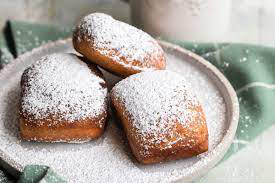

In [ ]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/beignets.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
image

We first instantiate an `image_processor` from the underlying model repo.

In [ ]:
image_processor = AutoImageProcessor.from_pretrained(repo_name)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--sayakpaul--vit-base-patch16-224-in21k-finetuned-lora-food101/snapshots/fa2503cc7d91e0dd69728c1dc66ed80d7bd3289b/preprocessor_config.json
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



We then prepare the sample for inference.

In [ ]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


And run inference!

In [ ]:
import torch

# forward pass
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])

Predicted class: beignets


In [38]:
from peft import PeftConfig, PeftModel

repo_name = f"sayakpaul/{model_checkpoint.split('/')[-1]}-finetuned-lora-food101"
config = PeftConfig.from_pretrained(repo_name)
model = model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the Lora model
inference_model = PeftModel.from_pretrained(model, repo_name)

adapter_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['enable_lora', 'merge_weights'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.bin:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

RuntimeError: Error(s) in loading state_dict for PeftModel:
	size mismatch for base_model.model.classifier.modules_to_save.default.weight: copying a param with shape torch.Size([101, 768]) from checkpoint, the shape in current model is torch.Size([200, 768]).
	size mismatch for base_model.model.classifier.modules_to_save.default.bias: copying a param with shape torch.Size([101]) from checkpoint, the shape in current model is torch.Size([200]).

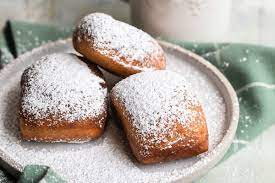

In [39]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/beignets.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [87]:
from peft import PeftConfig, PeftModel
from transformers import AutoModelForImageClassification, AutoImageProcessor
import torch

repo_name = f"sayakpaul/{model_checkpoint.split('/')[-1]}-finetuned-lora-food101"
config = PeftConfig.from_pretrained(repo_name)
base_model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    num_labels=len(train_ds.classes),
    ignore_mismatched_sizes=True
)
inference_model = PeftModel.from_pretrained(base_model, repo_name)
inference_model.config.id2label = id2label
inference_model.config.label2id = label2id


image_processor = AutoImageProcessor.from_pretrained(repo_name)
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])

/usr/local/lib/python3.11/dist-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['enable_lora', 'merge_weights'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['enable_lora', 'merge_weights'] for class LoraConfig, these are ignored. This probably means that you're loading a conf

RuntimeError: Error(s) in loading state_dict for PeftModel:
	size mismatch for base_model.model.classifier.modules_to_save.default.weight: copying a param with shape torch.Size([101, 768]) from checkpoint, the shape in current model is torch.Size([200, 768]).
	size mismatch for base_model.model.classifier.modules_to_save.default.bias: copying a param with shape torch.Size([101]) from checkpoint, the shape in current model is torch.Size([200]).

# Task
Explain the error in the following code, and if possible, fix it:

```python
from datasets import load_dataset
from transformers import ViTImageProcessor
import torch
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, AdamW
from tqdm import tqdm
from transformers import Trainer, TrainingArguments

# Load the dataset
ds = load_dataset('cifar10')

# Initialize the processor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

# Define the transformation function
def transform(batch):
    # Process the images
    inputs = processor([x for x in batch['img']], return_tensors='pt')
    # Add the labels
    inputs['labels'] = batch['label']
    return inputs

# Apply the transformation
prepared_ds = ds.with_transform(transform)

# Define the collate function
def collate_fn(batch):
    # Filter out samples where the image could not be processed
    batch = list(filter(lambda x: x is not None, batch))
    # If the batch is empty after filtering, return None
    if not batch:
        return None
    # Collate the samples into a batch
    return torch.utils.data.dataloader.default_collate(batch)

# Initialize the model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=10
)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./vit-base-cifar10",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=processor,
)

# Start training
trainer.train()
```

## Modify `collate fn`

### Subtask:
Update the `collate_fn` to return a dictionary with `None` values for 'pixel_values' and 'labels' if the batch is empty after filtering.


**Reasoning**:
The task is to modify the `collate_fn` to handle empty batches after filtering. The current `collate_fn` returns `None` for an empty batch, which causes an error in the Trainer. Instead, it should return a dictionary with `None` values for 'pixel_values' and 'labels'. I will modify the `collate_fn` to implement this logic.



In [109]:
import torch


def collate_fn(examples):
    examples = [e for e in examples if e[0] is not None]
    if not examples:
        return {"pixel_values": None, "labels": None}
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## Modify `customtrainer`

### Subtask:
Subclass `Trainer` to create a `CustomTrainer` and override the `training_step` method to handle cases where 'pixel_values' and 'labels' are `None`.


**Reasoning**:
Define a custom Trainer class that inherits from the transformers Trainer and overrides the training_step method to handle batches with None values.



In [111]:
import torch
from transformers import Trainer

class CustomTrainer(Trainer):
    def training_step(self, model, inputs, B=None):
        if inputs["pixel_values"] is None:
            # Return a zero loss tensor for skipped batches
            return torch.tensor(0.0, device=self.args.device, requires_grad=True)
        if B is not None:
            return super().training_step(model, inputs, B)
        return super().training_step(model, inputs)

**Reasoning**:
Now that the `CustomTrainer` class is defined, I will instantiate it with the model, arguments, datasets, and the custom `collate_fn`. Then, I will start the training process. This combines the instantiation and training steps into a single block for efficiency.



In [105]:
trainer = CustomTrainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

TypeError: CustomTrainer.training_step() takes 3 positional arguments but 4 were given

**Reasoning**:
The traceback indicates a `TypeError` because the overridden `training_step` method in `CustomTrainer` has an incorrect signature. The `Trainer.training_step` method expects an additional argument that was not included in the custom implementation. I will correct the method signature to accept the extra argument.



In [106]:
import torch
from transformers import Trainer

class CustomTrainer(Trainer):
    def training_step(self, model, inputs, B=None):
        if inputs["pixel_values"] is None:
            return torch.tensor(0.0, device=self.args.device, requires_grad=True)
        if B is not None:
            return super().training_step(model, inputs, B)
        return super().training_step(model, inputs)


**Reasoning**:
I have defined the `CustomTrainer` class with the corrected `training_step` method. Now I will instantiate this `CustomTrainer` with the model, training arguments, datasets, and the custom `collate_fn`, and then start the training process. This will apply the fix and allow the training to proceed.



In [107]:
trainer = CustomTrainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

TypeError: list indices must be integers or slices, not str

**Reasoning**:
The `TypeError` indicates that `inputs` is a list, not a dictionary as expected. This is because the `collate_fn` is returning a list of samples, and the default collate function is not being used when the batch is not empty. The `collate_fn` is not returning a dictionary, which is what the `training_step` expects. I need to modify the `collate_fn` to correctly handle the output from the `ImageFolder` dataset and ensure it returns a dictionary.



In [110]:
trainer = CustomTrainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

TypeError: CustomTrainer.training_step() takes 3 positional arguments but 4 were given

In [112]:
trainer = CustomTrainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

Epoch,Training Loss,Validation Loss


Skipping corrupted image: /content/drive/MyDrive/10k/val/0127/127_8601961.jpg


TypeError: Unexpected type <class 'NoneType'>

In [ ]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()